# Housing Prices Dataset Notebook
## Yosi Levi, PhD student

# Table of Contents
1. [Introduction](#sec1)
2. [Load and check Data](#sec2)
3. [EDA](#sec3)
    * [3.1 Joining train and test set](#sec3.1)
    * [3.2 Univariate Analysis](#sec3.2)
    * [3.3 Bi-variate Analysis](#sec3.3)
4. [Data Preprocessing](#sec4)
    * [4.1 Removing redundant features](#sec4.1)
    * [4.2 Dealing with Outliers](#sec4.2)
    * [4.3 Filling Missing Values](#sec4.3)
5. [Feature Engineering](#sec5)
6. [Modeling](#sec6)
    * [6.1 Scaling of features](#sec6.1)
    * [6.2 Model selection with K-Fold Cross Validation](#sec6.2)
    * [6.3 Hyperparameter Tuning using Randomized Search](#sec6.3)
    * [6.4 Ensemble modeling](#sec6.4)
    * [6.5 Prediction](#sec6.5)


<a id="sec1"></a>
# [1. Introduction](#sec1)
This notebook demonstrated a step-by-step approach to solving a House Pricing regression problem. First, we will explore a housing pricing dataset using Python libraries and prepare the dataset for model training. Second, we will consider different machine learning (ML) algorithms with the preprocessed data and tune the hyperparameters for the best ML models out of all the models that were examined. Lastly, we will combine the tuned ML models using a voting regressor to form the final predictions.

<a id="sec2"></a>
# [2. Load and check Data](#sec2)

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet, ARDRegression, BayesianRidge
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report, auc
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor
sns.set_palette("Set2")

In [109]:
#collect the data
train = pd.read_csv('/home/yosi/Symptoms_Detection/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/home/yosi/Symptoms_Detection/house-prices-advanced-regression-techniques/test.csv')

print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 81)
test:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
def get_missing_values(data):
    """
    This function finds the missing values in the dataset
    ...
    Attributes
    ----------
    data : Pandas DataFrame
    The data you want to see information about

    Returns
    ----------
    A Pandas Series contains the missing values in descending order
    """
    #get the sum of all missing values in the dataset
    missing_values = data.isnull().sum()
    #sorting the missing values in a pandas Series
    missing_values = missing_values.sort_values(ascending = False)

    #returning the missing values Series
    return missing_values

In [55]:
def _info_(data):
    """
    This function shows some information about the data like
    Feature names,data type, number of missing values for each feature
    and ten samples of each feature
    ...
    Attributes
    ----------
    data : Pandas DataFrame
        The data you want to see information about

    Returns
    ----------
    Information about the DataFrame
    """
    feature_dtypes = data.dtypes
    missing_values = get_missing_values(data)
    feature_names = missing_values.index.values
    missing_values = missing_values.values
    rows, columns = data.shape

    print("=" * 50)
    print('====> This data contains {} rows and {} columns'.format(rows,columns))
    print("=" * 50)
    print()

    print("{:15} {:15} {:15}".format('Feature Name'.upper(),
                                           'Data Format'.upper(),
                                           'Null values (% Null out of data len)'.upper()))
    for feature_name, dtype, missing_value in zip(feature_names,feature_dtypes[feature_names], missing_values):
        print("{:15} {:14} {:20}".format(feature_name,
                                         str(dtype),
                                         str(missing_value) + ' - ' +
                                         str(round(100 * missing_value / len(data), 3)) + ' %'), end = "")
        print()

    print("=" * 50)

### Print basic information of the data set

In [56]:
_info_(train)

====> This data contains 1460 rows and 81 columns

FEATURE NAME    DATA FORMAT     NULL VALUES (% NULL OUT OF DATA LEN)
PoolQC          object         1453 - 99.521 %     
MiscFeature     object         1406 - 96.301 %     
Alley           object         1369 - 93.767 %     
Fence           object         1179 - 80.753 %     
FireplaceQu     object         690 - 47.26 %       
LotFrontage     float64        259 - 17.74 %       
GarageYrBlt     float64        81 - 5.548 %        
GarageCond      object         81 - 5.548 %        
GarageType      object         81 - 5.548 %        
GarageFinish    object         81 - 5.548 %        
GarageQual      object         81 - 5.548 %        
BsmtFinType2    object         38 - 2.603 %        
BsmtExposure    object         38 - 2.603 %        
BsmtQual        object         37 - 2.534 %        
BsmtCond        object         37 - 2.534 %        
BsmtFinType1    object         37 - 2.534 %        
MasVnrArea      float64        8 - 0.548 %      

It can be shown that some of the features have a high percentage of missing values. Those features will be removed, cause they do not provide any useful information to the ML model.

In [57]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [58]:
train.describe(include = ['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Convert MSSubClass to category variable

In [59]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
#train['MSSubClass'] = train['MSSubClass'].astype('object')

Drop Id columns

In [60]:
train = train.drop(columns = ['Id'])

Get nominal, Numerical, and categorical column names

Define nominal feature list

In [61]:
nominal_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
               'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

Get the numerical variable

In [62]:
numeric_var = train.select_dtypes(exclude = ['object']).drop(columns = nominal_var)
numeric_var.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

Get the categorical variable

In [63]:
category_var = train.select_dtypes(include = ['object'])
category_var.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

<a id="sec3"></a>
# [3. EDA](#sec3)

<a id="sec3.1"></a>
## [3.1 Univariate Analysis](#sec3.1)

### Numeric features

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


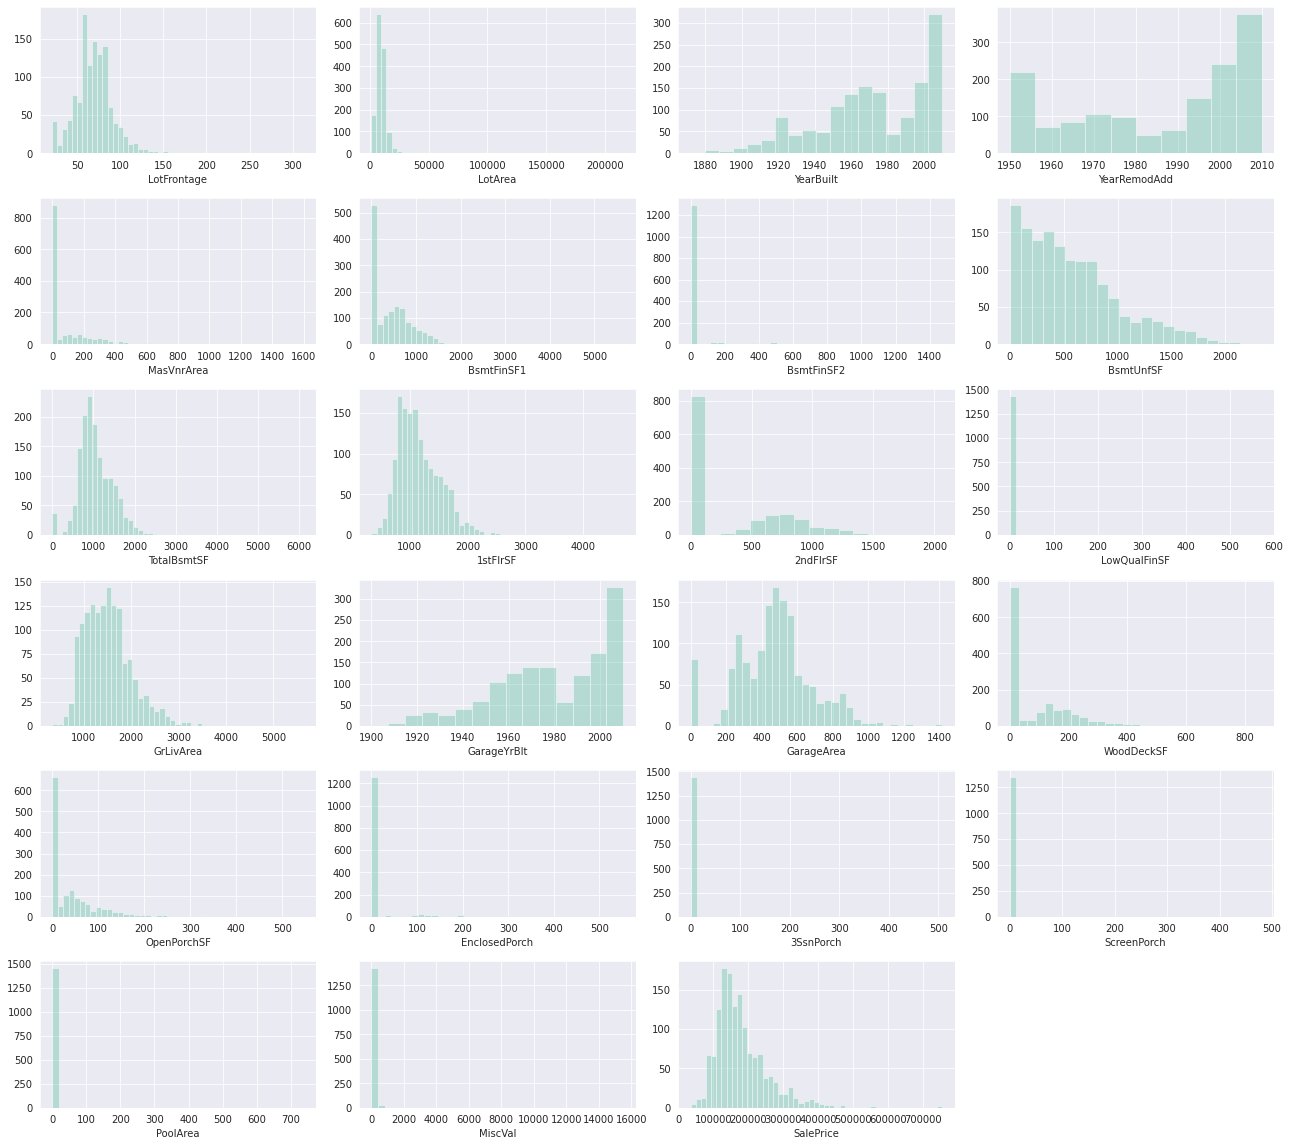

In [64]:
num_col = 4
num_row = math.ceil(len(numeric_var.columns) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(numeric_var):
    plt.subplot(num_row, num_col, index + 1)
    sns.distplot(train.loc[:, col], kde = False)
    #sns.histplot(data = numeric_var, x=col, kde=False)
fig.tight_layout(pad = 1.0)

It can be shown that some of the features have almost constant value:
1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal

All these features do not provide any information to an ML model. Therefore, we will remove them during our preprocessing step

Plot box plot for numerical features

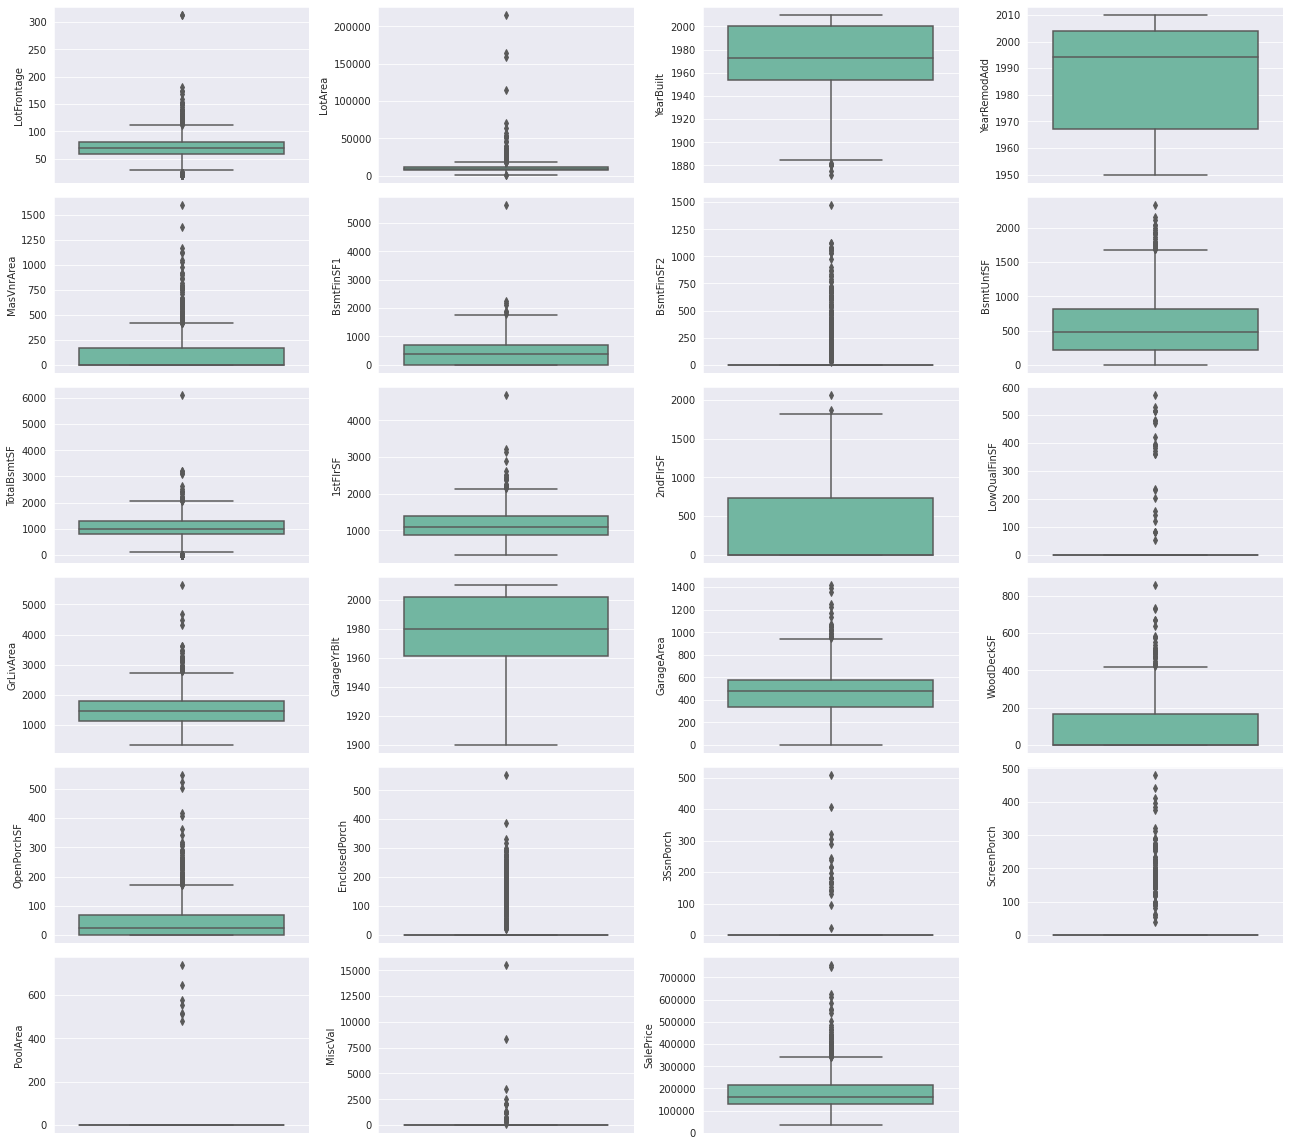

In [65]:
num_col = 4
num_row = math.ceil(len(numeric_var.columns) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(numeric_var):
    plt.subplot(num_row,num_col, index + 1)
    sns.boxplot(y = train.loc[:, col])
fig.tight_layout(pad = 1.0)

### Nominal features

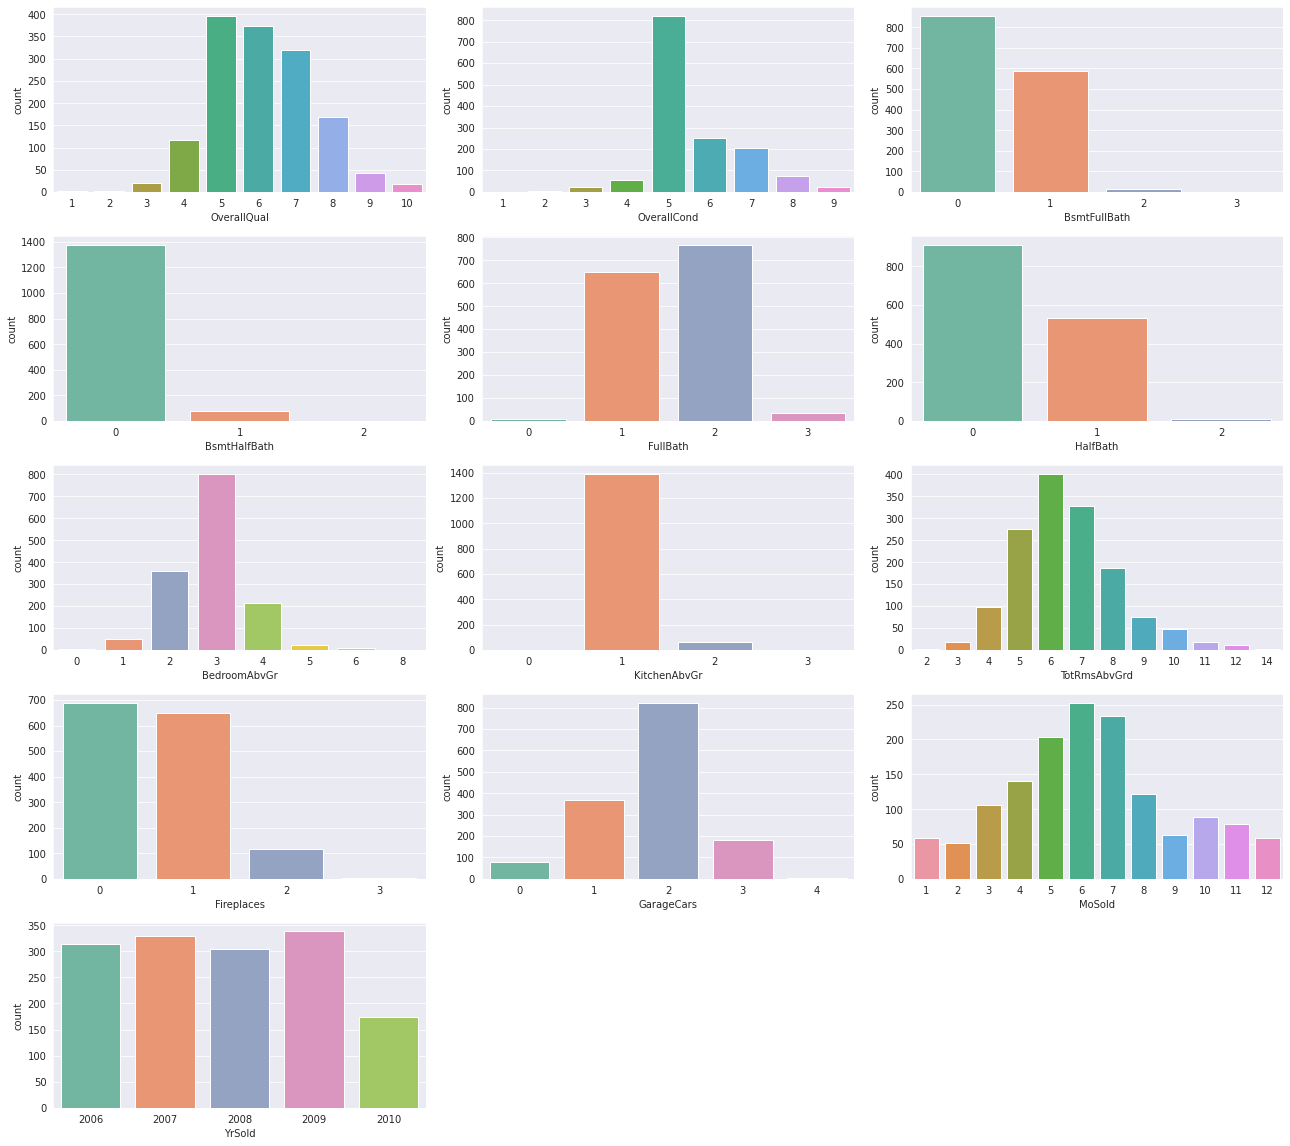

In [66]:
num_col = 3
num_row = math.ceil(len(nominal_var) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(nominal_var):
    plt.subplot(num_row, num_col, index + 1)
    sns.countplot(x = train.loc[:, col])
fig.tight_layout(pad = 1.0)

### Categorical features

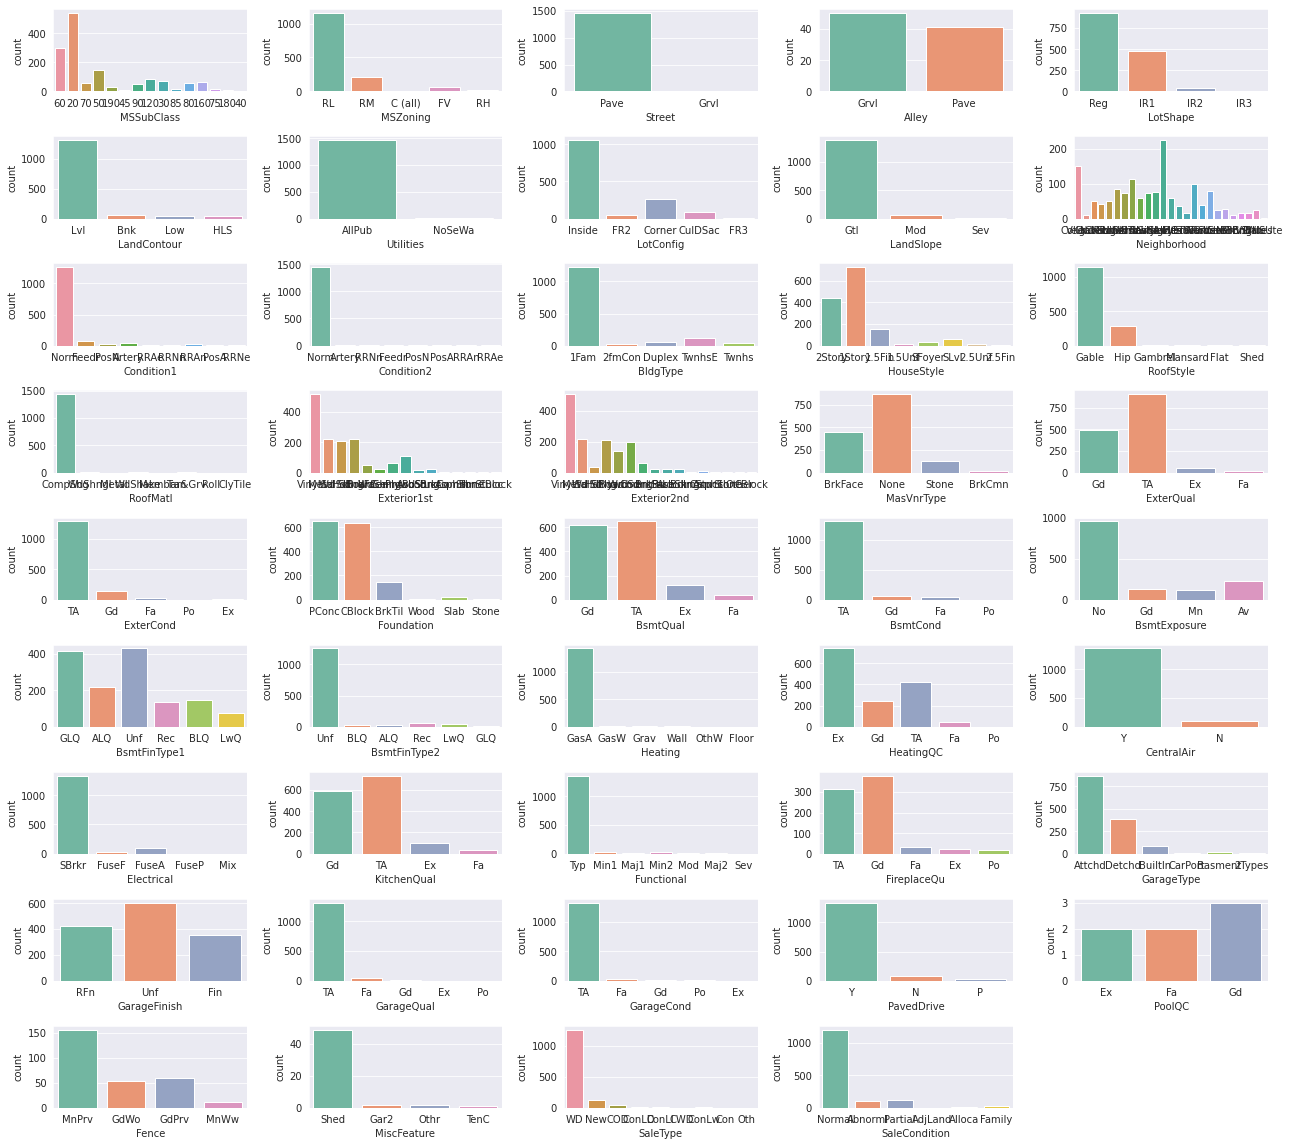

In [67]:
num_col = 5
num_row = math.ceil(len(category_var.columns) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(category_var):
    plt.subplot(num_row, num_col, index + 1)
    sns.countplot(x = train.loc[:, col])
fig.tight_layout(pad = 1.0)

It can be shown that the features **Utilities** and **Condition2** mainly consist of distinct value. therefore, these features do not provide any information to an ML model,and we will remove them during our preprocessing step.


Univariate Analysis helps us to understand all the features better, on an individual scale. To further deepen our insights and uncover potential pattern in the data, we will also need to find out more about the relationship between all these features with one another, which brings us to our next step in our analysis - Bivariate Analysis

<a id='sec3.2'></a>
## [3.2 Bi-Variate Analysis](#sec3.2)

### Correlation matrix

In [68]:
# Create a matrix from the data
matrix = train.select_dtypes(exclude = ['object']).corr()

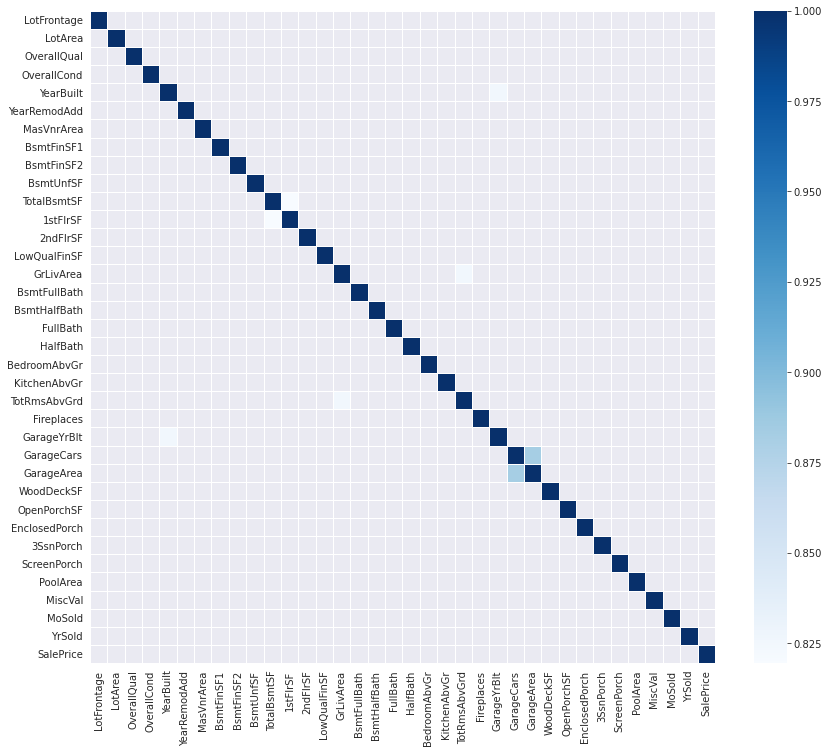

In [69]:
sns.set_style("darkgrid")
fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(111)
sns.heatmap(matrix, cmap = 'Blues', linewidth = 1, linecolor = 'white', ax = ax1, square = False, mask = matrix < 0.8)
plt.show()

It can be shown that some of the features are highly correlated with each other (multicollinearity). This situation causes to precision loss in regression coefficients and affecting the reliability in the identification of the most important features to the prediction. Therefore, we will remove one feature out of each pair of correlated features.

### Identifying linear relationship between numerical predictor and target variable (*SalePrice*)

In [70]:
numeric_nominal_var_train = train.select_dtypes(exclude = ['object'])
matrix = numeric_nominal_var_train.corr()
matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

The table above present the correlation of each numerical feature with the target variable. It can be shown that some of the features have a strong linear relationship with SalePrice and can serve as good predictors of the Housing Price.


### Scatterplot
Identifying any relationship (E.g Linear, Quadratic, Exponential) between numerical predictor and target variable (*SalePrice*)
using scatterplot.

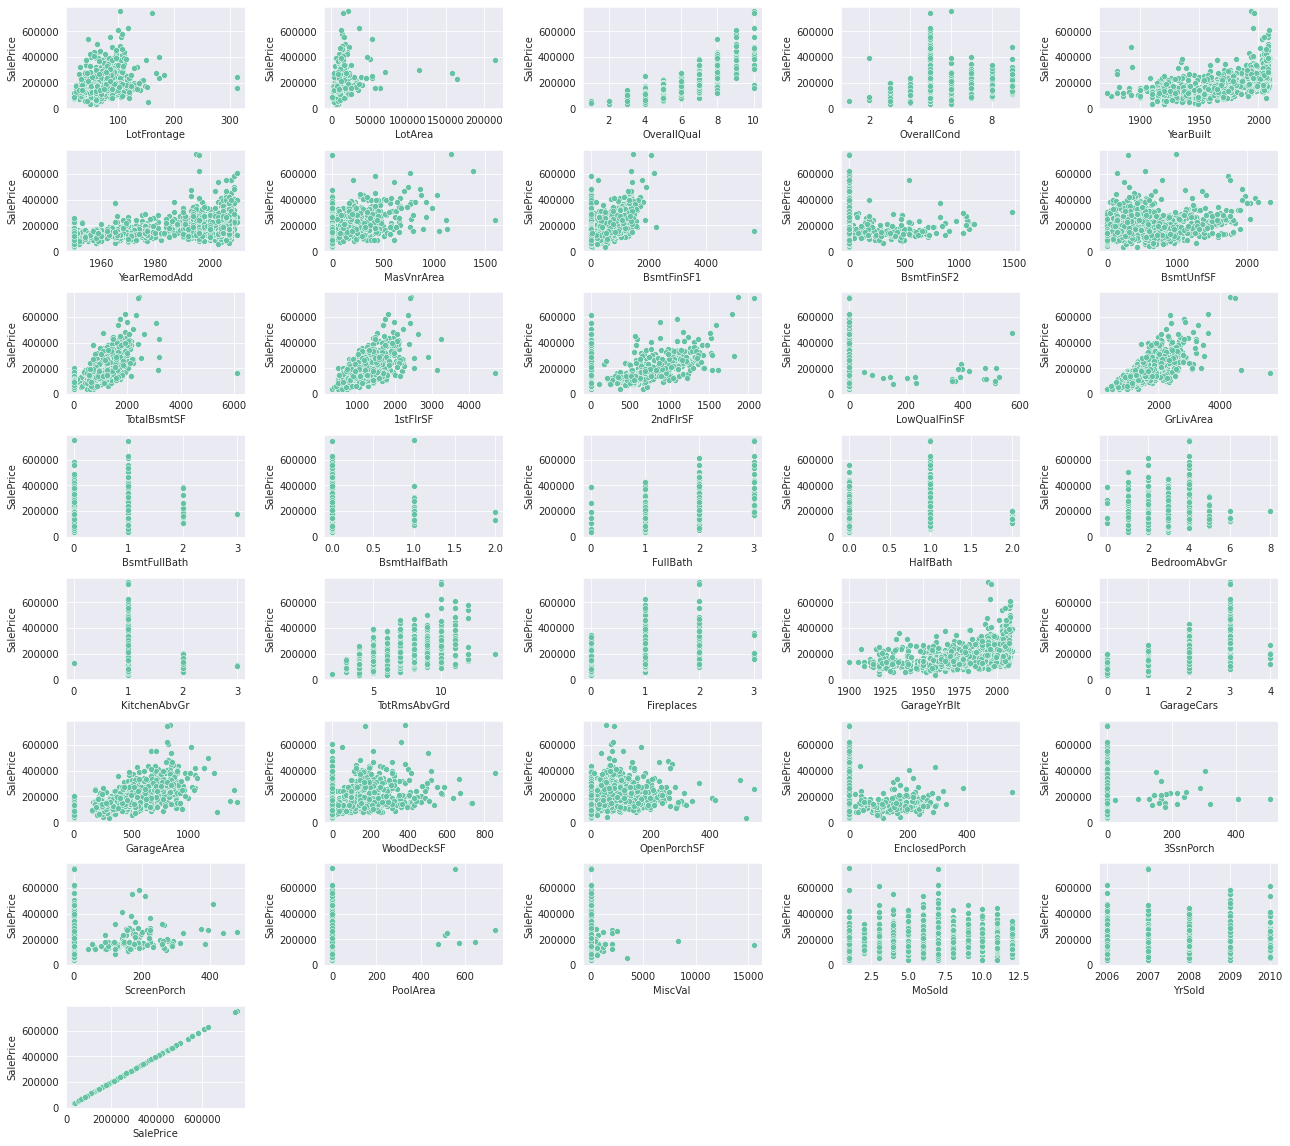

In [71]:
num_col = 5
num_row = math.ceil(len(numeric_nominal_var_train.columns) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(numeric_nominal_var_train):
    plt.subplot(num_row, num_col, index + 1)
    sns.scatterplot(data = numeric_nominal_var_train, x = col, y = 'SalePrice')
    #sns.scatterplot(x = numeric_nominal_var_train.loc[:,col], y=numeric_nominal_var_train['SalePrice'])
fig.tight_layout(pad = 1.0)

It can be shown that some of the feature have linear relationship with the target variable (SalePrice). The quantitative of the linear relationship are provided in the table above.

### Boxplot
Check distributions of (*SalePrice*) vis differences categorical\nominal features

Nominal features

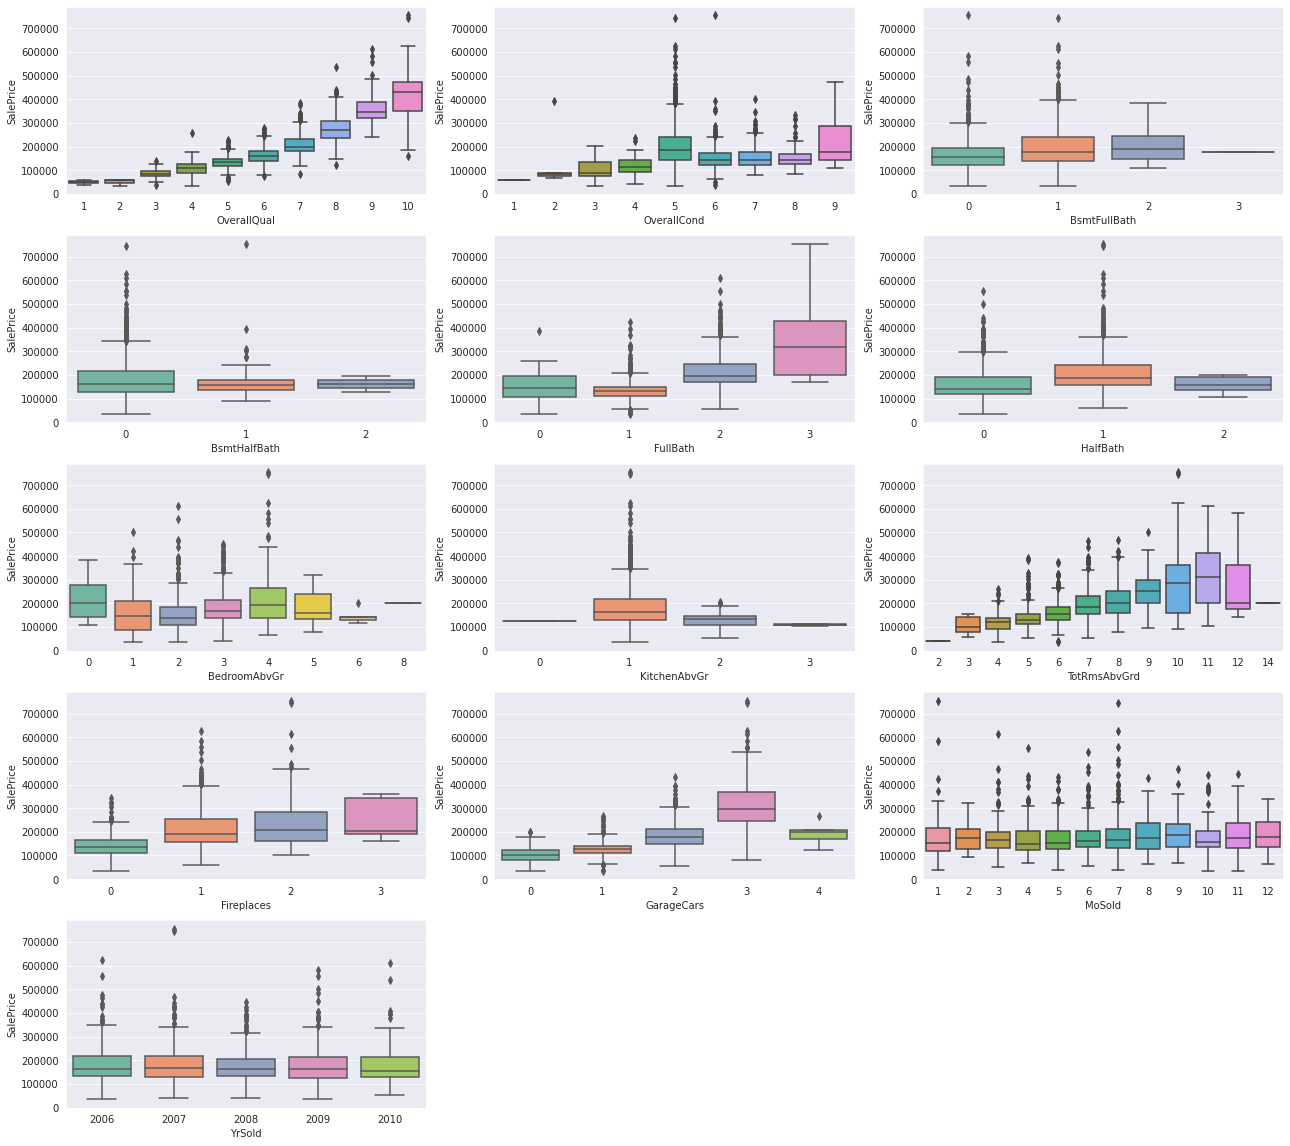

In [72]:
num_col = 3
num_row = math.ceil(len(nominal_var) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(nominal_var):
    plt.subplot(num_row, num_col, index + 1)
    sns.boxplot(data = train[nominal_var + ['SalePrice']], x = col, y = 'SalePrice')
fig.tight_layout(pad = 1.0)

Categorical features

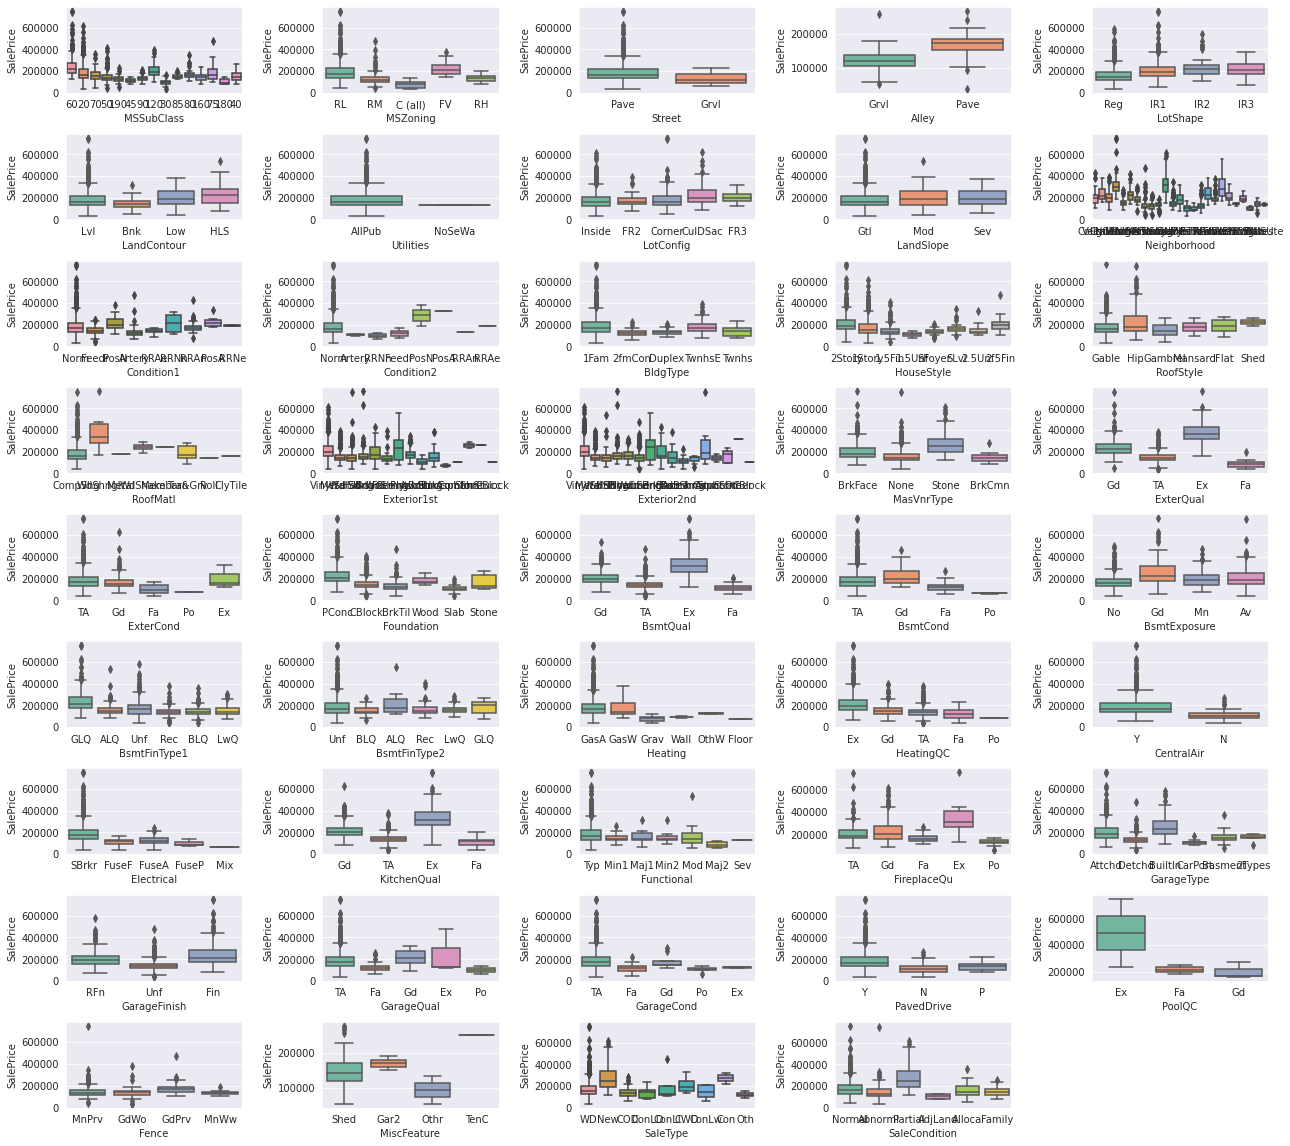

In [73]:
num_col = 5
num_row = math.ceil(len(category_var.columns) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(category_var.columns):
    plt.subplot(num_row, num_col, index + 1)
    sns.boxplot(data = train[list(category_var.columns) + ['SalePrice']], x = col, y = 'SalePrice')
fig.tight_layout(pad = 1.0)

It can be shown that the distribution of price between the different categories values differs, as such those features could potentially be a predictors of SalePrice.

<a id = 'sec4'></a>
# [4. Data Processing](#sec4)
This section outlines the steps for Data Processing:
1. Removing Redundant Features
2. Dealing with Outliers
3. Filling in missing values

<a id="sec4.1"></a>
## [4.1 Removing Redundant Features](#sec4.1)

### Remove features with a lot of missing values
We have shown above (see "Print basic information of the data set") that the features **PoolQC**, **MiscFeature**, **Alley**, and **Fence** have a high percentage of missing values (>80%). Therefore we will remove them cause they can't provide useful information to our ML model.

In [74]:
train = train.drop(columns = ['PoolQC','MiscFeature','Alley'])

### Remove features with multicollinearity

Find the names of the features which are highly correlated (r>=0.8)


In [75]:
# Create a matrix from the data
matrix = train.select_dtypes(exclude = ['object']).corr()
res= []
for i in range (matrix.shape[0]):
    for j in range (i+1, matrix.shape[0]):
        if matrix.iloc[i,j] >= 0.8:
            res.append([matrix.columns[i], matrix.columns[j], matrix.iloc[i, j]])
res

[['YearBuilt', 'GarageYrBlt', 0.8256674841743408],
 ['TotalBsmtSF', '1stFlrSF', 0.8195299750050339],
 ['GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425],
 ['GarageCars', 'GarageArea', 0.882475414281462]]

We will remove one feature for each pair of features that are highly correlated to avoid the problem of multicollinearity.

In [76]:
train = train.drop(columns=['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'])

### Removing features with almost constant value
We found during the invariant analysis step that some features mostly consist of a single value or 0s. Those features do not provide any useful information to our ML model. We use threshold 0f 96%. Namely, a feature that has value that appears 96% out of the feature-length, will be removed.

In [77]:
def get_quasi_constant(df):
    res = []
    for col in df:
        frac = df[col].value_counts(normalize = True, dropna = False).iloc[0]
        if frac > 0.96:
            res.append(col)
    return res

In [78]:
quasi_constant = get_quasi_constant(train)
train = train.drop(columns = quasi_constant)

### Remove features without relationship with the target variable (*SalePrice*)

Get the numeric feature names that have not been removed yet and plot a scatterplot between them and the target variable.

In [79]:
numeric_feature_list = list(set(train.columns).intersection(numeric_nominal_var_train.columns))
numeric_feature_list

['BsmtFullBath',
 'LotArea',
 'YearBuilt',
 'BsmtUnfSF',
 'EnclosedPorch',
 'BedroomAbvGr',
 'OverallQual',
 'BsmtFinSF2',
 'KitchenAbvGr',
 '2ndFlrSF',
 'TotalBsmtSF',
 'WoodDeckSF',
 'ScreenPorch',
 'MoSold',
 'YearRemodAdd',
 'GarageArea',
 'GrLivArea',
 'BsmtFinSF1',
 'OverallCond',
 'FullBath',
 'MasVnrArea',
 'HalfBath',
 'SalePrice',
 'Fireplaces',
 'BsmtHalfBath',
 'OpenPorchSF',
 'LotFrontage',
 'YrSold']

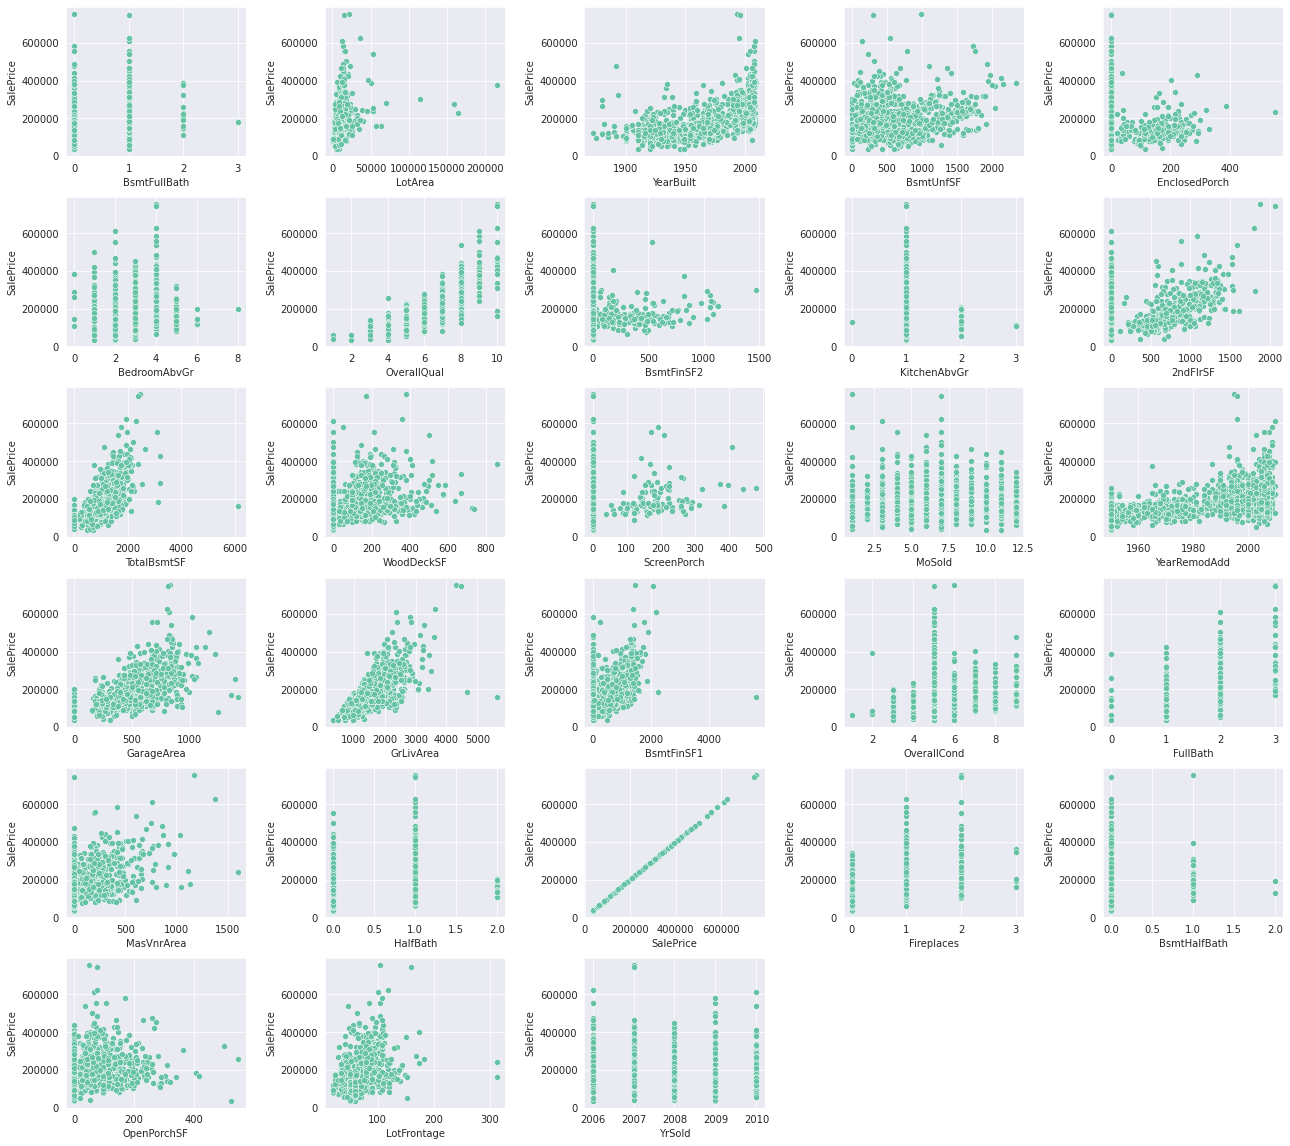

In [80]:
num_col = 5
num_row = math.ceil(len(numeric_feature_list) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(numeric_nominal_var_train[numeric_feature_list]):
    plt.subplot(num_row, num_col, index + 1)
    sns.scatterplot(data = numeric_nominal_var_train[numeric_feature_list], x = col, y = 'SalePrice')
    #sns.scatterplot(x = numeric_nominal_var_train.loc[:,col], y=numeric_nominal_var_train['SalePrice'])
fig.tight_layout(pad = 1.0)

The features **YrSold** and **MoSold** does not have any linear relationship (see also correlation table) with the target variable and hence we will drop them.

In [81]:
train = train.drop(columns = ['MoSold', 'YrSold'])

In [82]:
def drop_features(df, features):
    df = df.drop(columns = features)
    return df

<a id="sec4.2"></a>
## [4.2 Dealing with Outliers](#sec4.2)

Plot a boxplot to the numeric feature which did not remove yet.

In [83]:
numeric_feature_list = list(set(train.columns).intersection(numeric_var.columns))

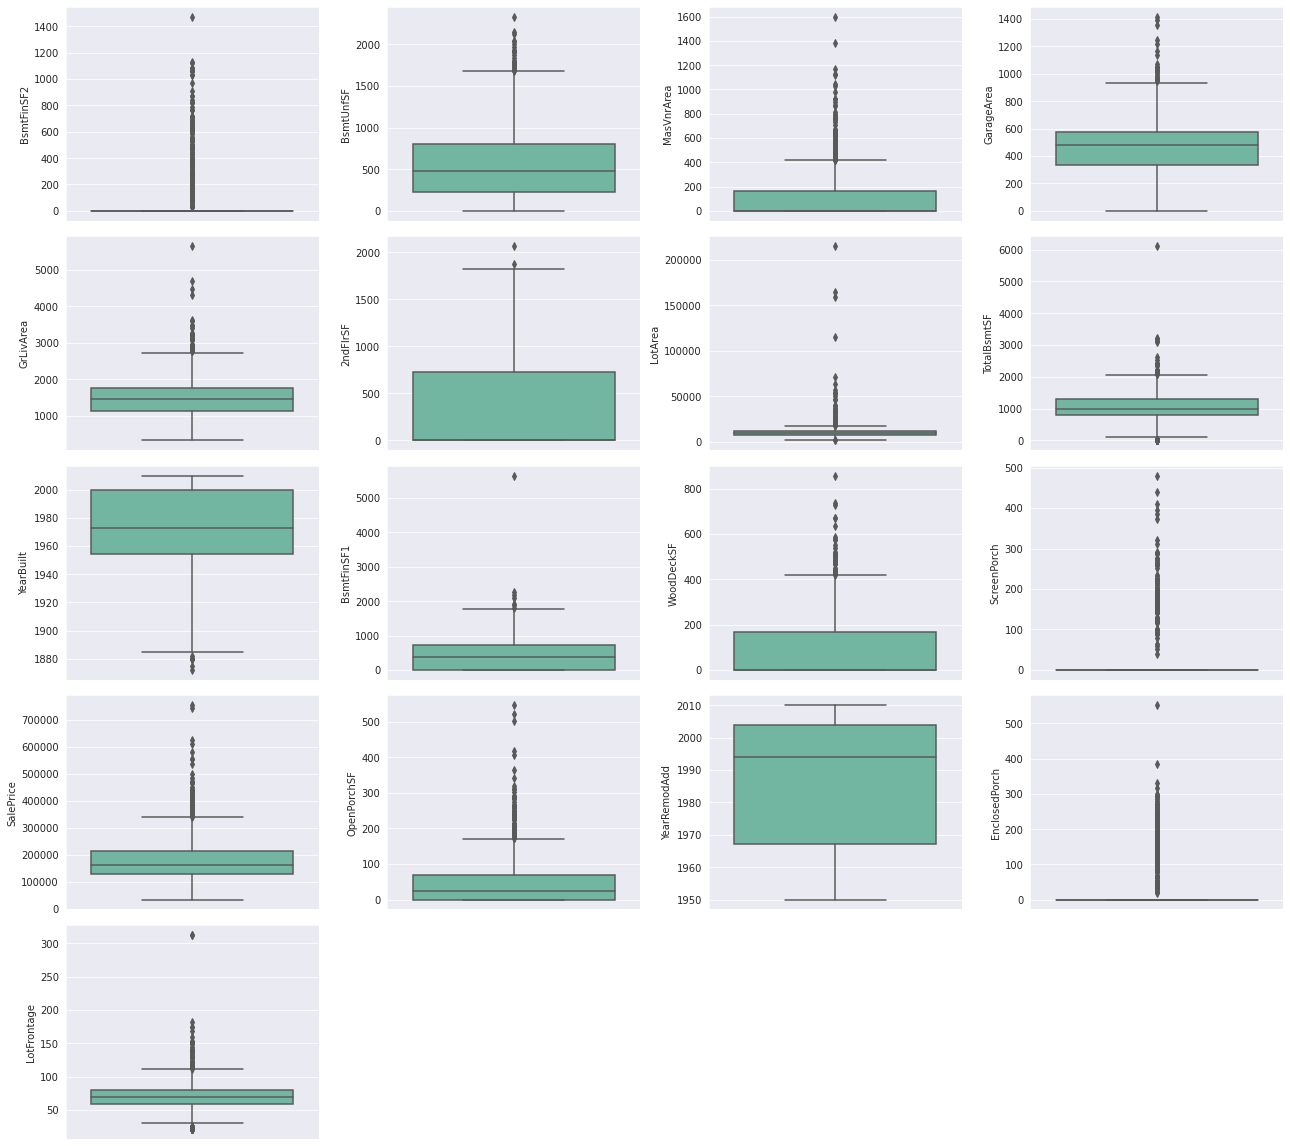

In [84]:
num_col = 4
num_row = math.ceil(len(numeric_feature_list) / num_col)
fig = plt.figure(figsize = (18, 16))
for index, col in enumerate(numeric_var[numeric_feature_list]):
    plt.subplot(num_row, num_col, index + 1)
    sns.boxplot(y = numeric_var.loc[:, col])
fig.tight_layout(pad = 1.0)

The features **BsmtFinSF1**,**TotalBsmtSF**,**LotArea**,**GrLivArea**, and **LotFrontage** have considerable outliers, therefore we will remove them to get better performance in our ML model.

In [85]:
outlier_feature_list = ['BsmtFinSF1', 'TotalBsmtSF', 'LotArea', 'GrLivArea', 'LotFrontage']

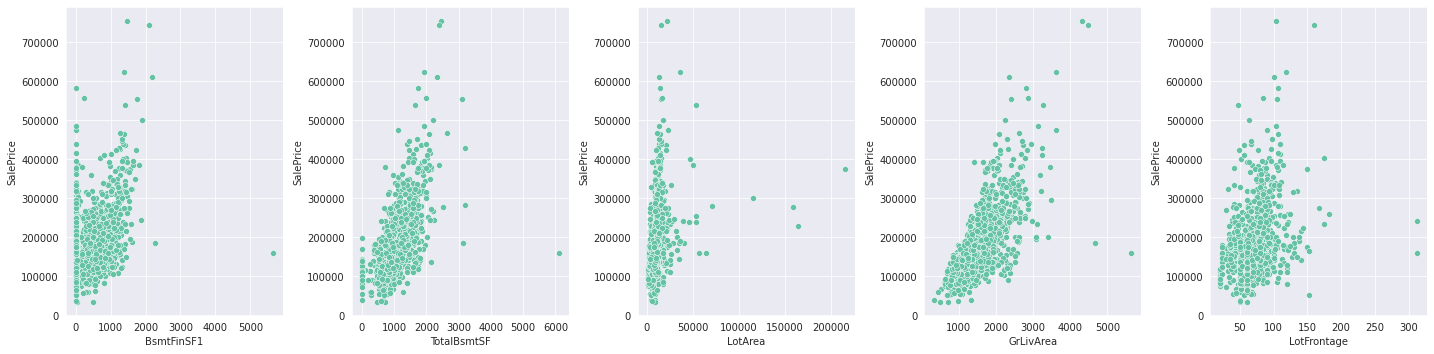

In [86]:
num_col = 5
num_row = math.ceil(len(outlier_feature_list) / num_col)
fig = plt.figure(figsize = (20, 5))
for index, col in enumerate(numeric_var[outlier_feature_list]):
    plt.subplot(num_row, num_col, index + 1)
    sns.scatterplot(data = numeric_nominal_var_train, x = col, y = 'SalePrice')
fig.tight_layout(pad = 1.0)

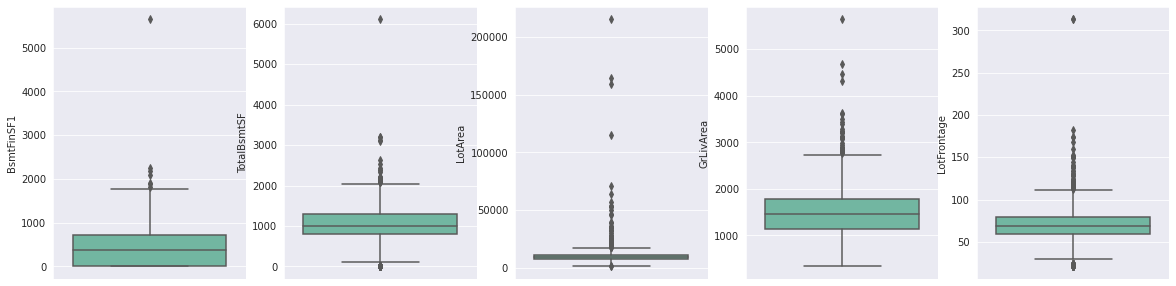

In [87]:
num_col = 5
num_row = math.ceil(len(outlier_feature_list) / num_col)
fig = plt.figure(figsize = (20, 5))
for index, col in enumerate(numeric_var[outlier_feature_list]):
    plt.subplot(num_row, num_col, index + 1)
    sns.boxplot(y = numeric_var.loc[:, col])

In [88]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)
train = train.reset_index(drop = True)

<a id="sec4.3"></a>
## [4.3 Filling Missing Values](#sec4.3)

Print the missing values in the remaining features

In [89]:
_info_(train)

====> This data contains 1451 rows and 62 columns

FEATURE NAME    DATA FORMAT     NULL VALUES (% NULL OUT OF DATA LEN)
Fence           object         1171 - 80.703 %     
FireplaceQu     object         690 - 47.553 %      
LotFrontage     float64        256 - 17.643 %      
GarageCond      object         81 - 5.582 %        
GarageQual      object         81 - 5.582 %        
GarageType      object         81 - 5.582 %        
GarageFinish    object         81 - 5.582 %        
BsmtFinType2    object         38 - 2.619 %        
BsmtExposure    object         38 - 2.619 %        
BsmtCond        object         37 - 2.55 %         
BsmtQual        object         37 - 2.55 %         
BsmtFinType1    object         37 - 2.55 %         
MasVnrType      object         8 - 0.551 %         
MasVnrArea      float64        8 - 0.551 %         
Electrical      object         1 - 0.069 %         
BedroomAbvGr    int64          0 - 0.0 %           
HalfBath        int64          0 - 0.0 %        

In [90]:
# Create a categorical feature list whose values include the NA option
na_col = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
'GarageType', 'GarageFinish','GarageQual','GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
# Create a list with the feature names that contain missing values
missing_value_col = train.loc[:, (train.isnull().sum() > 0).T].columns.to_list()
# Find the intersection between na_col and missing_value_col lists
cat_na_col = list(set(na_col).intersection(set(missing_value_col)))
# Fill missing values with 'NA' in the cat_na_col columns
train[cat_na_col] = train[cat_na_col].fillna('NA')
_info_(train)

====> This data contains 1451 rows and 62 columns

FEATURE NAME    DATA FORMAT     NULL VALUES (% NULL OUT OF DATA LEN)
LotFrontage     float64        256 - 17.643 %      
MasVnrArea      float64        8 - 0.551 %         
MasVnrType      object         8 - 0.551 %         
Electrical      object         1 - 0.069 %         
MSSubClass      object         0 - 0.0 %           
Fireplaces      int64          0 - 0.0 %           
2ndFlrSF        int64          0 - 0.0 %           
GrLivArea       int64          0 - 0.0 %           
BsmtFullBath    int64          0 - 0.0 %           
BsmtHalfBath    int64          0 - 0.0 %           
FullBath        int64          0 - 0.0 %           
HalfBath        int64          0 - 0.0 %           
BedroomAbvGr    int64          0 - 0.0 %           
KitchenAbvGr    int64          0 - 0.0 %           
KitchenQual     object         0 - 0.0 %           
Functional      object         0 - 0.0 %           
FireplaceQu     object         0 - 0.0 %        

### Categorical features
We will replace the missing value of our categorical features with the most frequent occurrence (mode) value which corresponding to its Neighborhood.

In [91]:
cat_col = train.select_dtypes(include = ['object']).columns.to_list()
for col in cat_col:
    train[col] = train.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features
We will replace the missing value of our numerical features with the mean value which corresponding to its Neighborhood.


In [92]:
num_col = train.select_dtypes(exclude=['object']).columns.to_list()
for col in num_col:
    train[col] = train.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.mean()))

### Filling missing values function

In [93]:
def fillna(df,fill_strategies,):
    """
    This function fills NA/NaN values in a specific column using a specified method (zero,mean,mode,...)
    ...
    Attributes
    ----------
    data : Pandas DataFrame. The data you want to impute its missing values
    fill_strategies : A dictionary that its keys represent the columns,
    and the values represent the value to use to fill the Nulls.

    Returns
    ----------
    A new dataset without null values.
    """

    for tuple_col, fill_with in fill_strategies.items():
        for col in tuple_col:
            if str(fill_with).lower() in ['zero', 0]:
                df[col] = df[col].fillna(0)
            elif str(fill_with).lower() == 'mode':
                df[col] = df[col].fillna(df[col].mode()[0])
            elif str(fill_with).lower() == 'mean':
                df[col] = df[col].fillna(df[col].mean())
            elif str(fill_with).lower() == 'median':
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(fill_with)
    return df

In [94]:
def fillna_group(df,fill_strategies,group=False):
    """
    This function fills NA/NaN values in a specific column using a specified method (zero,mean,mode,...)
    ...
    Attributes
    ----------
    data : Pandas DataFrame. The data you want to impute its missing values
    fill_strategies : A dictionary that its keys represent the columns,
    and the values represent the value to use to fill the Nulls.
    group : A column name for groupby and fill the missing value corresponding to its subgroup


    Returns
    ----------
    A new dataset without null values.
    """
    if group:
        for tuple_col, fill_with in fill_strategies.items():
            for col in tuple_col:
                if str(fill_with).lower() in ['zero', 0]:
                    df[col] = df[col].fillna(0)
                elif str(fill_with).lower() == 'mode':
                    df[col] = df.groupby(group)[col].transform(lambda x: x.fillna(x.mode()[0]))
                elif str(fill_with).lower() == 'mean':
                    df[col] = df.groupby(group)[col].transform(lambda x: x.fillna(x.mean()))
                elif str(fill_with).lower() == 'median':
                    df[col] = df.groupby(group)[col].transform(lambda x: x.fillna(x.median()))
                else:
                    df[col] = df[col].fillna(fill_with)
    else:
        for tuple_col, fill_with in fill_strategies.items():
            for col in tuple_col:
                if str(fill_with).lower() in ['zero', 0]:
                    df[col] = df[col].fillna(0)
                elif str(fill_with).lower() == 'mode':
                    df[col] = df[col].fillna(df[col].mode()[0])
                elif str(fill_with).lower() == 'mean':
                    df[col] = df[col].fillna(df[col].mean())
                elif str(fill_with).lower() == 'median':
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(fill_with)
    return df

### Mapping Ordinal Features
Convert categorical features that have ordinal meaning to a number which represents their rank.

In [95]:
def mapping_ordinal_features(df, features, classes):
    for col in features:
        le = LabelEncoder()
        le.fit(df[col])
        le.classes_ = np.array(classes)
        df[col] = le.transform(df[col])
    return df

In [96]:
ordina_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']
ordinal_class = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
fintype_col = ['BsmtFinType1', 'BsmtFinType2']
fintype_class = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
exposure_col = ['BsmtExposure']
expose_class = ['NA', 'No', 'Mn', 'Av', 'Gd']
Fence_col = ['Fence']
fence_class = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

In [97]:
train = mapping_ordinal_features(train.copy(), ordina_col, ordinal_class)
train = mapping_ordinal_features(train.copy(), fintype_col, fintype_class)
train = mapping_ordinal_features(train.copy(), exposure_col, expose_class)
train = mapping_ordinal_features(train.copy(), Fence_col, fence_class)

<a id = 'sec5'></a>
# [5. Feature Engineering](#sec5)
Create new features that could potentially aid in predicting our target variable.
The following features will be taken under consideration:

* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms

* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade

* MasVnrArea: Masonry veneer area in square feet (0 if none exists)
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area (0 if none exists)

* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* GrLivArea: Above grade (ground) living area square feet

* WoodDeckSF: Wood deck area in square feet (0 if none exists)

* OpenPorchSF: Open porch area in square feet (0 if none exists)
* EnclosedPorch: Enclosed porch area in square feet (0 if none exists)
* ScreenPorch: Screen porch area in square feet (0 if none exists)

<a id='sec5'><a>
# [5. Feature Engineering](#sec5)
Create new features that could potentially aid in predicting our target variable.
The following features will be taken under consideration:

* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms

* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade

* MasVnrArea: Masonry veneer area in square feet (0 if none exists)
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area (0 if none exists)

* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* GrLivArea: Above grade (ground) living area square feet

* WoodDeckSF: Wood deck area in square feet (0 if none exists)

* OpenPorchSF: Open porch area in square feet (0 if none exists)
* EnclosedPorch: Enclosed porch area in square feet (0 if none exists)
* ScreenPorch: Screen porch area in square feet (0 if none exists)

### Numeric features

In [98]:
# TotalLot: Total lot area
train['TotalLot'] = train['LotFrontage'] + train['LotArea']
# TotalBath: Total bathrooms (half/full) in the basement
train['TotalBsmtBath'] = train['BsmtFullBath'] + train['BsmtHalfBath']
# TotalBath: Total bathrooms (half/full) above grade
train['TotalBath'] = train['FullBath'] + train['HalfBath']
# TotalPorch: Total Porch area (screened, covered and uncovered areas)
train['TotalPorch'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['ScreenPorch']

### Binary features
Some of the numeric features including 0s value, indicate the absence of the feature. This information could contribute to the creation of another binary feature that indicates the **presence (1) or absence (0)** of those features.

In [99]:
columns = ['MasVnrArea','TotalBsmtSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','TotalPorch']

for col in columns:
    col_name = col + '_bin'
    train[col_name] = train[col].apply(lambda x: 1 if x > 0 else 0)

### SalePrice Distribution

It can be shown that the distribution of the target variable is skewed to the right (positive skewness). This senior can reduce the overall performance of our ML model. Therefore, we will apply **log transformation** on the target variable (*SalePrice*) in an attempt to minimize the skewness of the distribution.

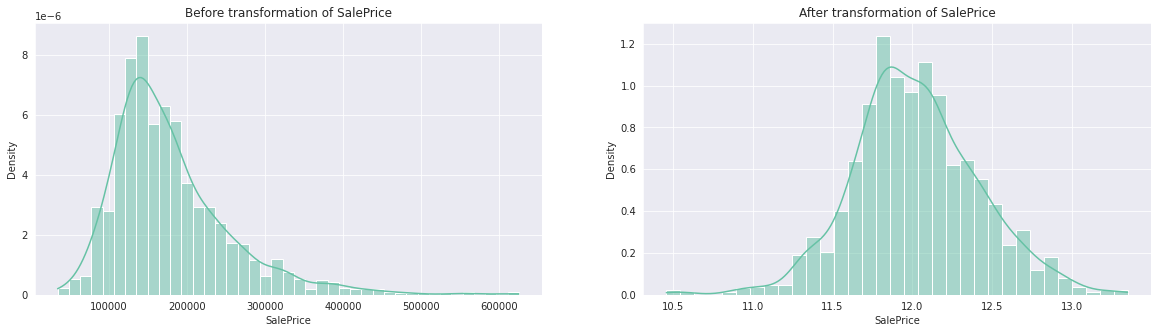

In [100]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(data = train, x = 'SalePrice', stat = "density", ax = ax1, kde = True)
sns.histplot(data = np.log(train['SalePrice']), stat = "density", ax = ax2, kde = True)
ax1.set_title("Before transformation of SalePrice")
ax2.set_title("After transformation of SalePrice")
plt.show()

Apply **log transformation** on the target variable.

In [101]:
train["SalePrice"] = np.log(train['SalePrice'])

### Main function
This function get data set and preprocess it based on the EDA and Feature engineering perform on the training set. The preprocessing applied to the training set has to be applied also on the test set.

In [103]:
def main(df, training = True):

    ############################# Data Processing #############################

    # Convert MSSubClass to category variable
    df['MSSubClass'] = df['MSSubClass'].apply(str)

    # Removing Redundant Features
    # drop_features_list = ['Id','PoolQC','MiscFeature','Alley','GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars','MoSold','YrSold'] + get_quasi_constant(train)
    drop_features_list = ['PoolQC', 'MiscFeature', 'Alley', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars',
     'MoSold', 'YrSold', 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF','3SsnPorch',
                          'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'Id']
    df = df.drop(columns=drop_features_list)

    # Dealing with Outliers
    if training:
        df = df.drop(df[df['LotFrontage'] > 200].index)
        df = df.drop(df[df['LotArea'] > 100000].index)
        df = df.drop(df[df['BsmtFinSF1'] > 4000].index)
        df = df.drop(df[df['TotalBsmtSF'] > 5000].index)
        df = df.drop(df[df['GrLivArea'] > 4000].index)
        df = df.reset_index(drop = True)

    # Fill missin values

    # Create a categorical feature list whose values include the NA option
    na_col = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
    # Create a list with the feature names that contain missing values
    missing_value_col = df.loc[:, (df.isnull().sum() > 0).T].columns.to_list()
    # Find the intersection between na_col and missing_value_col lists
    cat_na_col = list(set(na_col).intersection(set(missing_value_col)))
    # Find categorical features
    cat_col = df.select_dtypes(include = ['object']).columns.to_list()
    # Find numerical features
    num_col = df.select_dtypes(exclude = ['object']).columns.to_list()
    # Create fill strategies dictionary
    fill_strategies = {tuple(cat_na_col):'NA', tuple(cat_col):'mode', tuple(num_col):'mean'}
    # Fill missing values by strategies
    df = fillna_group(df.copy(), fill_strategies, 'Neighborhood')


    # Mapping Ordinal Features

    ordina_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']
    ordinal_class = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    fintype_col = ['BsmtFinType1', 'BsmtFinType2']
    fintype_class = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
    exposure_col = ['BsmtExposure']
    expose_class = ['NA', 'No', 'Mn', 'Av', 'Gd']
    Fence_col = ['Fence']
    fence_class = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
    df = mapping_ordinal_features(df.copy(),ordina_col,ordinal_class)
    df = mapping_ordinal_features(df.copy(),fintype_col,fintype_class)
    df = mapping_ordinal_features(df.copy(),exposure_col,expose_class)
    df = mapping_ordinal_features(df.copy(),Fence_col,fence_class)

    ############################# Feature engineering #############################

    # Numeric features
    df['TotalLot'] = df['LotFrontage'] + df['LotArea'] # TotalLot: Total lot area
    df['TotalBsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] # TotalBath: Total bathrooms (half/full) in the basement
    df['TotalBath'] = df['FullBath'] + df['HalfBath'] # TotalBath: Total bathrooms (half/full) above grade
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch'] # TotalPorch: Total Porch area (screened, covered and uncovered areas)
    # Binary features
    columns = ['MasVnrArea', 'TotalBsmtSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'TotalPorch']
    for col in columns:
        col_name = col + '_bin'
        df[col_name] = df[col].apply(lambda x: 1 if x > 0 else 0)
    # Apply log transformation on the target variable
    if training:
        df["SalePrice"] = np.log(df['SalePrice'])
    return df

### Read data

In [103]:
#collect the data
train = pd.read_csv('/home/yosi/Symptoms_Detection/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/home/yosi/Symptoms_Detection/house-prices-advanced-regression-techniques/test.csv')

print("train: ", train.shape)
print("test: ", test.shape)

train:  (1460, 81)
test:  (1459, 80)


# Data Processing and Feature Engineering

The test set should ideally not be preprocessed with the training data. Our EDA, Data processing, and feature engineering are performed only on the train set separately to avoid data leakage. Once the training data is preprocessed, we can apply the same preprocessing parameters used for the train set, onto the test set as though the test set didn't exist before.

In [104]:
train = main(train.copy())
test = main(test.copy(), False)

### Converting Categorical to Numerical
To prevent a senario which a categorical variable has more features in the test set then in the training set when one-hot encoded, we will combine the training and test sets, apply one-hot encoding to the combined dataset, and then split it back into training and test sets.

In [105]:
def pandas_tt(train, test):
    out = pd.concat([train.drop(columns = ['SalePrice']), test],ignore_index = True)
    out =  pd.get_dummies(out)
    return pd.concat([out[:len(train)], train['SalePrice']], axis = 1), out[len(train):].reset_index(drop=True)

In [106]:
train, test = pandas_tt(train, test)

<a id='sec6'></a>
# [6. Modeling](#sec6)
In this section, we will fit different machine learning algorithms with our preprocessed data. We will estimate the model's performance out of multiple ones, using the k-fold cross-validation. Afterward, we will tune the hyperparameters of the best models.


<a id='sec6.1'></a>
## [6.1 Scaling of Data](#sec6.1)
**RobustScaler** is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data.

In [107]:
x = train.drop(columns=['SalePrice'])
y = train['SalePrice']
scaler = RobustScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), columns = x.columns)
test = pd.DataFrame(scaler.transform(test), columns = test.columns)

<a id='sec6.2'></a>
## [6.2 Model selection with K-Fold Cross Validation](#sec6.2)

In [120]:
regressors = {
    "XGBRegressor": XGBRegressor(objective = 'reg:squarederror'),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "SVR": SVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
}

### K-fold Cross Validation

In [121]:
kfold = KFold(n_splits=10)
df_models = pd.DataFrame(columns=['Model', 'Mean MAE', 'Std MAE'])
for key in regressors:
    model = regressors[key]
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=kfold)
    df_models = pd.concat([df_models, pd.DataFrame([[key, -1 * scores.mean(), scores.std()]], columns = df_models.columns)])
df_models = df_models.sort_values(by = ['Mean MAE'], ascending = False).reset_index(drop = True)
df_models

,Model,Mean MAE,Std MAE
0,ElasticNet,0.151700,0.019525
1,SVR,0.064797,0.011652
2,DecisionTreeRegressor,0.038123,0.005935
3,KernelRidge,0.035100,0.009569
4,RandomForestRegressor,0.018354,0.004676
5,XGBRegressor,0.014669,0.004521
6,LinearRegression,0.013842,0.003743
7,Ridge,0.012995,0.003508
8,BayesianRidge,0.012431,0.003335


### Plot model performance

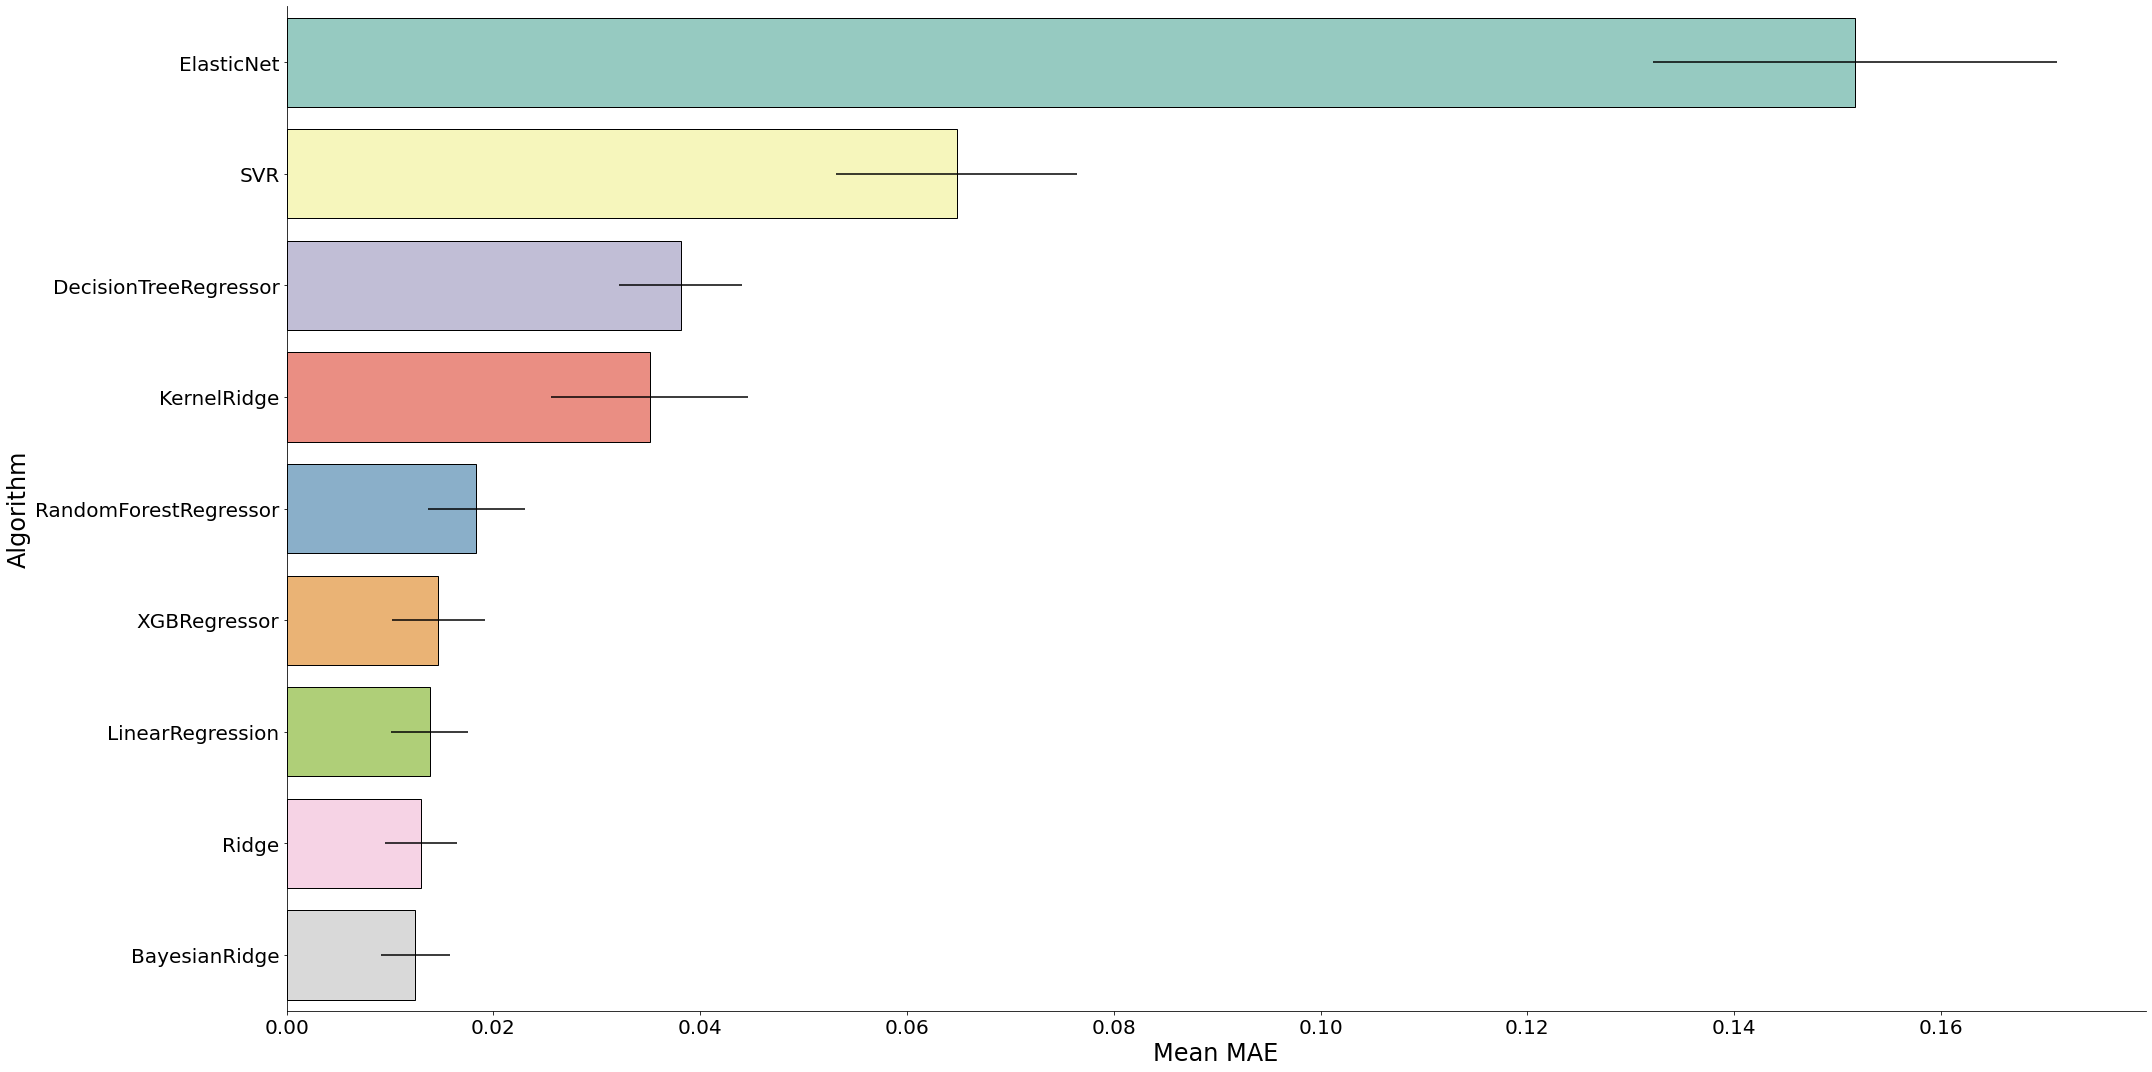

In [122]:
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)
sns.barplot(data = df_models ,y = 'Model', x = 'Mean MAE', linewidth = 1, edgecolor = 'black', palette = 'Set3', **{'xerr':df_models['Std MAE']})

# set x labels
ax.set_xlabel("Mean MAE", fontsize = 24)
# set y labels
ax.set_ylabel("Algorithm", fontsize = 24)

# set x tick labels
ax.xaxis.set_tick_params(labelsize = 20)
# set y tick labels
ax.yaxis.set_tick_params(labelsize = 20)

sns.despine(fig = None, ax = None, top = True, right = True, left = False, bottom = False, offset = None, trim = False)
fig.tight_layout()
plt.show()

<a id='sec6.3'></a>
## [6.3 Hyperparameter Tuning using Randomized Search](#sec6.3)
We will tune the hyper-parameters for the 3 best regressors i.e the BayesianRidge, Ridge, and XGBRegressor.



#### BayesianRidge HyperParameter Tuning

In [115]:
br = BayesianRidge()
param_lst = {'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5,None],
             'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9,None]
}
br_search = RandomizedSearchCV(estimator = br, param_distributions = param_lst,
                               scoring = 'neg_mean_squared_error', cv = 10)
br_search.fit(x,y)
br_search.best_score_

-0.012430522764779118

In [113]:
br = BayesianRidge()
param_lst = {'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, None],
             'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9, None]
             }
br_search = GridSearchCV(estimator = br, param_grid = param_lst,
                         scoring = 'neg_mean_squared_error', cv = 10)
br_search.fit(x, y)
br_search.best_score_

-0.01243052276477866

#### Ridge HyperParameter Tuning

In [118]:
ridge = Ridge()
param_lst = {'alpha':[0.5, 1, 10, 20, 25, 30, 35, 40, 45, 50, 55, 57, 60, 65, 70, 75, 80, 100], 'max_iter':[10000]}

ridge_search = RandomizedSearchCV(estimator = ridge, param_distributions = param_lst,
                               n_iter = 100, scoring = 'neg_mean_squared_error', cv = 10)
ridge_search.fit(x, y)
ridge_search.best_score_

-0.01240345068925283

#### XGBoost HyperParameter Tuning

In [170]:
xgbr = XGBRegressor(objective = 'reg:squarederror')
param_lst = {
    'learning_rate':[0.1, 0.5],
    'max_depth':[5, 10, 15],
    'n_estimators':[100, 500, 1000],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha':[0, 0.5],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgbr_search = RandomizedSearchCV(estimator = xgbr, param_distributions = param_lst,
                                 n_iter = 100, scoring = 'neg_mean_squared_error', cv = 10)
xgbr_search.fit(x, y)
xgbr_search.best_score_

-0.013766637974590285

<a id='sec6.4'></a>
## [6.4 Ensemble modeling](#sec6.4)
We will combine predictions from our best 3 models. The prediction is an average prediction of all the submodels.

In [171]:
voting_reg = VotingRegressor(estimators=[('br', br_search), ('ridge', ridge_search), ('xgbr', xgbr_search)])
voting_reg.voting = "soft"
voting_reg.fit(x, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


VotingRegressor(estimators=[('br',
                             RandomizedSearchCV(cv=10,
                                                estimator=BayesianRidge(),
                                                param_distributions={'alpha_init': [1,
                                                                                    1.1,
                                                                                    1.2,
                                                                                    1.3,
                                                                                    1.4,
                                                                                    1.5,
                                                                                    None],
                                                                     'lambda_init': [0.1,
                                                                                     0.01,
                                                                                     0.001,
                                                                                     0.0001,
                                                                                     1e-05,
                                                                                     1e-06,
                                                                                     1e-09,
                                                                                     None]},
                                                scoring='neg_mean_squared_error')),
                            ('ridge',
                             RandomizedSearchCV(cv=10, estimator=Ridge(),
                                                n_iter=100,
                                                param_distributions={'alpha': [0.5,
                                                                               1,
                                                                               10,
                                                                               20,...
                                                                     'max_iter': [10000]},
                                                scoring='neg_mean_squared_error')),
                            ('xgbr',
                             RandomizedSearchCV(cv=10,
                                                estimator=XGBRegressor(objective='reg:squarederror'),
                                                n_iter=100,
                                                param_distributions={'learning_rate': [0.1,
                                                                                       0.5],
                                                                     'max_depth': [5,
                                                                                   10,
                                                                                   15],
                                                                     'min_child_weight': [1,
                                                                                          5,
                                                                                          10,
                                                                                          20],
                                                                     'n_estimators': [100,
                                                                                      500,
                                                                                      1000],
                                                                     'reg_alpha': [0,
                                                                                   0.5],
                                                                     'reg_lambda': [0.001,
                                                                                    0.01,
     

<a id='sec6.5'></a>
## [6.5 Prediction](#sec6.5)

In [172]:
submission = pd.DataFrame({'Id': np.arange(1461, 2920),
                           'SalePrice': np.exp(voting_reg.predict(test))})
submission['SalePrice'] = round(submission['SalePrice'], 3)
submission

,Id,SalePrice
0,1461,122438.150
1,1462,161533.953
2,1463,184584.715
3,1464,199618.210
4,1465,188576.530
...,...,...
1454,2915,83746.077
1455,2916,80782.398
1456,2917,165681.524
1457,2918,116654.394


In [173]:
submission.to_csv("submission.csv", index = False)

# End